In [30]:
pip install umap-learn


Note: you may need to restart the kernel to use updated packages.


Cube shape: (96, 96, 200)
Labels shape: (96, 96)
Filtered data shape: (9216, 200)
Filtered labels shape: (9216,)
PCA done: reduced to 33 components


C:\Users\raaya\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done


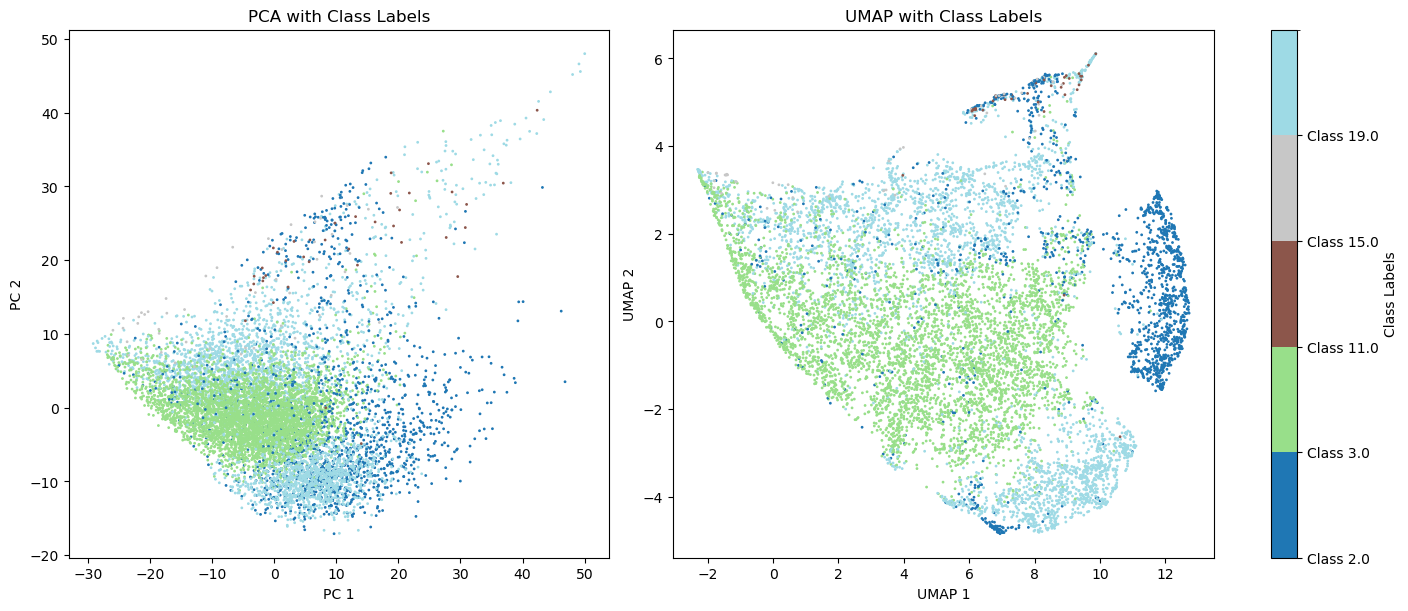

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.colors as mcolors
import os

# Load hyperspectral cube and labels
def load_data(data_path=r'C:\Users\raaya\Downloads\Test\rs\MJK_N_patch_101_10_1.npy',
              label_path=r'C:\Users\raaya\Downloads\Test\gt\MJK_N_patch_101_10_1.npy'):
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Make sure both data and label files exist.")
    cube = np.load(data_path)
    labels = np.load(label_path)
    return cube, labels

def reshape_cube_and_labels(cube, labels):
    h, w, bands = cube.shape
    data_flat = cube.reshape(-1, bands)
    labels_flat = labels.reshape(-1)
    return data_flat, labels_flat

def main():
    # Load data and labels
    cube, labels = load_data()
    print("Cube shape:", cube.shape)
    print("Labels shape:", labels.shape)

    data_flat, labels_flat = reshape_cube_and_labels(cube, labels)

    # Remove zero pixels (background) from data and labels together
    mask = ~np.all(data_flat == 0, axis=1)  # mask out zero pixels in data
    data_filtered = data_flat[mask]
    labels_filtered = labels_flat[mask]

    # Also remove pixels labeled as 0 in labels (background)
    nonzero_label_mask = labels_filtered != 0
    data_filtered = data_filtered[nonzero_label_mask]
    labels_filtered = labels_filtered[nonzero_label_mask]

    print(f"Filtered data shape: {data_filtered.shape}")
    print(f"Filtered labels shape: {labels_filtered.shape}")

    # Scale data
    data_scaled = StandardScaler().fit_transform(data_filtered)

    # PCA with 99% variance retention
    pca = PCA(n_components=0.99)
    pca_result = pca.fit_transform(data_scaled)
    print(f"PCA done: reduced to {pca_result.shape[1]} components")

    # UMAP embedding
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
    umap_result = reducer.fit_transform(pca_result)
    print("UMAP done")

    # Prepare colormap for classes
    classes = np.unique(labels_filtered)
    num_classes = len(classes)

    label_map = {label: idx for idx, label in enumerate(classes)}
    remapped_labels = np.array([label_map[l] for l in labels_filtered])

    base_cmap = plt.colormaps.get_cmap('tab20')
    cmap = mcolors.ListedColormap(base_cmap(np.linspace(0, 1, num_classes)))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(num_classes + 1), ncolors=num_classes)

    # Plot PCA and UMAP colored by class
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    scatter_pca = ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=remapped_labels, s=1, cmap=cmap, norm=norm)
    ax[0].set_title("PCA with Class Labels")
    ax[0].set_xlabel("PC 1")
    ax[0].set_ylabel("PC 2")

    scatter_umap = ax[1].scatter(umap_result[:, 0], umap_result[:, 1], c=remapped_labels, s=1, cmap=cmap, norm=norm)
    ax[1].set_title("UMAP with Class Labels")
    ax[1].set_xlabel("UMAP 1")
    ax[1].set_ylabel("UMAP 2")

    # Colorbar with class names
    cbar = fig.colorbar(scatter_umap, ax=ax, ticks=np.arange(num_classes))
    cbar.ax.set_yticklabels([f'Class {c}' for c in classes])
    cbar.set_label("Class Labels")

    plt.show()

if __name__ == "__main__":
    main()


Loaded HSI data with shape (9216, 200) after background removal
Data scaled to [0,1]: min=0.0000, max=1.0000
Epoch 1/100 | D Loss: 1.5835 | G Loss: 1.0070
Epoch 2/100 | D Loss: 1.4406 | G Loss: 0.8365
Epoch 3/100 | D Loss: 0.7119 | G Loss: 1.9003
Epoch 4/100 | D Loss: 1.0809 | G Loss: 0.9918
Epoch 5/100 | D Loss: 1.6121 | G Loss: 0.8528
Epoch 6/100 | D Loss: 0.5270 | G Loss: 1.7606
Epoch 7/100 | D Loss: 2.1678 | G Loss: 0.8298
Epoch 8/100 | D Loss: 0.6463 | G Loss: 1.5707
Epoch 9/100 | D Loss: 0.3721 | G Loss: 2.1754
Epoch 10/100 | D Loss: 2.0417 | G Loss: 0.9679
Epoch 11/100 | D Loss: 0.5060 | G Loss: 1.8212
Epoch 12/100 | D Loss: 0.7228 | G Loss: 1.4512
Epoch 13/100 | D Loss: 1.3331 | G Loss: 1.1191
Epoch 14/100 | D Loss: 1.0863 | G Loss: 1.0441
Epoch 15/100 | D Loss: 1.0518 | G Loss: 0.9603
Epoch 16/100 | D Loss: 1.6933 | G Loss: 0.6319
Epoch 17/100 | D Loss: 1.2161 | G Loss: 0.8668
Epoch 18/100 | D Loss: 1.2679 | G Loss: 0.8708
Epoch 19/100 | D Loss: 1.2045 | G Loss: 0.8831
Epoch 2

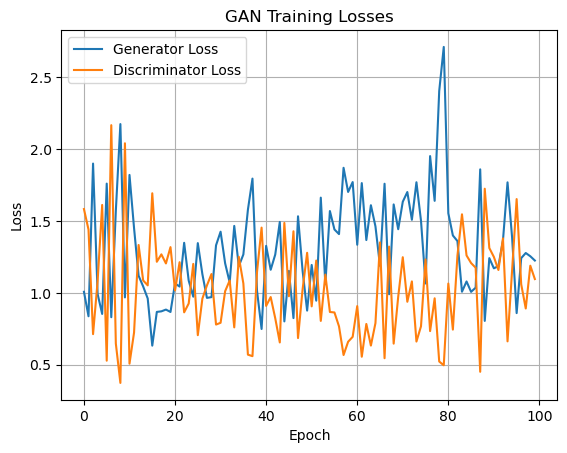

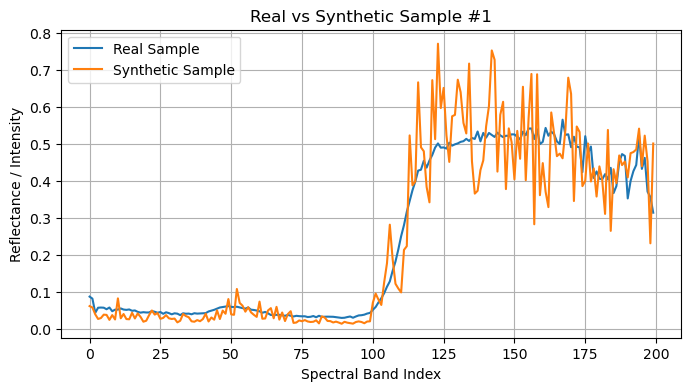

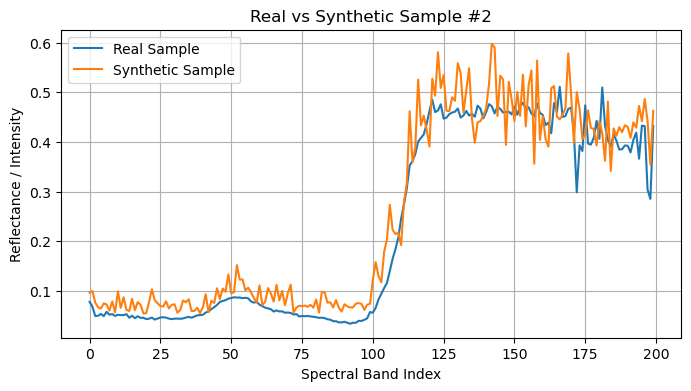

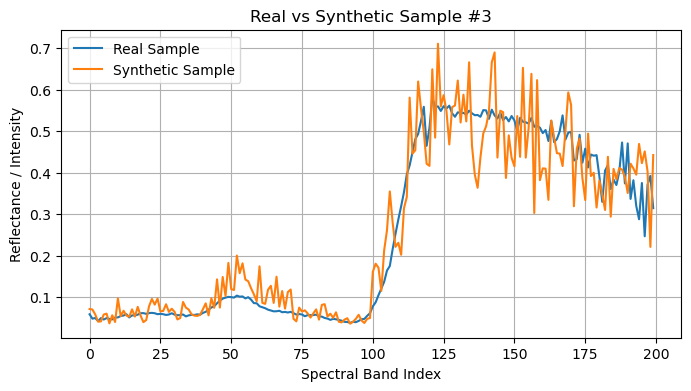

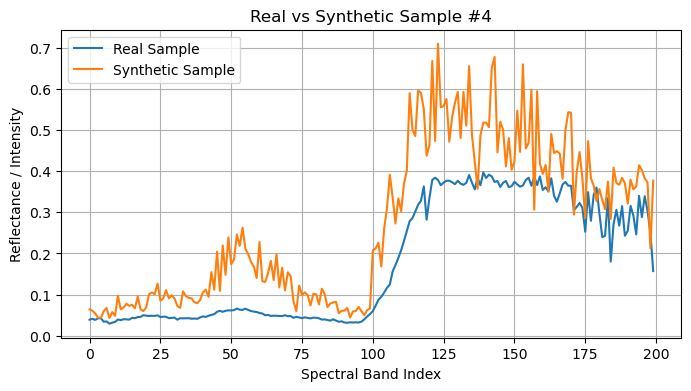

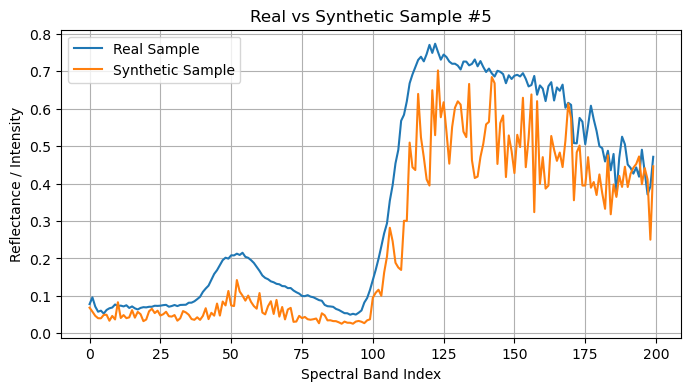

Saved 9216 synthetic full spectral samples to C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\3\original\synthetic_hsi_full.npy
Saved PCA-reduced real data: (9216, 30)
Saved PCA-reduced synthetic data: (9216, 30)
Average SAM with nearest neighbor: 8.78 degrees


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import random

explained_variance_threshold = 0.99
output_dir = r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\3\original'
os.makedirs(output_dir, exist_ok=True)

# === STEP 1: Load and preprocess UAV HSI dataset (full spectral) ===
def load_and_preprocess_hsi():
    cube = np.load(r'C:\Users\raaya\Downloads\Test\rs\MJK_N_patch_101_10_1.npy')  # (H, W, B)
    h, w, bands = cube.shape
    flat = cube.reshape(-1, bands)

    # Remove background pixels (all-zero)
    mask = ~np.all(flat == 0, axis=1)
    flat = flat[mask]

    # Scale to [0,1] for Sigmoid output in Generator
    scaler = MinMaxScaler()
    flat_scaled = scaler.fit_transform(flat)

    print(f"Loaded HSI data with shape {flat.shape} after background removal")
    print(f"Data scaled to [0,1]: min={flat_scaled.min():.4f}, max={flat_scaled.max():.4f}")

    return flat_scaled, scaler

# === STEP 2: Define GAN Components ===
class Generator(nn.Module):
    def __init__(self, latent_dim=100, output_dim=200):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()  # Output in [0,1]
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim=200):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# === STEP 3: Train GAN on scaled data ===
def train_gan(X_real_scaled, latent_dim=100, epochs=100, batch_size=128):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    G = Generator(latent_dim, X_real_scaled.shape[1]).to(device)
    D = Discriminator(X_real_scaled.shape[1]).to(device)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

    X_tensor = torch.tensor(X_real_scaled, dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

    losses = {'G': [], 'D': []}
    for epoch in range(epochs):
        for real_batch, in dataloader:
            real_batch = real_batch.to(device)
            b_size = real_batch.size(0)

            # Train Discriminator
            z = torch.randn(b_size, latent_dim).to(device)
            fake_samples = G(z).detach()

            real_labels = torch.ones(b_size, 1).to(device)
            fake_labels = torch.zeros(b_size, 1).to(device)

            loss_real = criterion(D(real_batch), real_labels)
            loss_fake = criterion(D(fake_samples), fake_labels)
            D_loss = loss_real + loss_fake

            optimizer_D.zero_grad()
            D_loss.backward()
            optimizer_D.step()

            # Train Generator
            z = torch.randn(b_size, latent_dim).to(device)
            gen_samples = G(z)
            G_loss = criterion(D(gen_samples), real_labels)

            optimizer_G.zero_grad()
            G_loss.backward()
            optimizer_G.step()

        losses['G'].append(G_loss.item())
        losses['D'].append(D_loss.item())
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

    return G, losses

# === STEP 4: Plot GAN losses ===
def plot_losses(losses):
    plt.plot(losses['G'], label='Generator Loss')
    plt.plot(losses['D'], label='Discriminator Loss')
    plt.legend()
    plt.title("GAN Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# === STEP 5: Visualize real vs synthetic samples ===
def visualize_real_vs_synthetic(G, real_scaled, scaler, latent_dim=100, num_samples=5):
    G.eval()
    device = next(G.parameters()).device

    z = torch.randn(num_samples, latent_dim).to(device)
    synthetic_scaled = G(z).detach().cpu().numpy()
    synthetic_orig = scaler.inverse_transform(synthetic_scaled)

    real_indices = random.sample(range(len(real_scaled)), num_samples)
    real_orig = scaler.inverse_transform(real_scaled[real_indices])

    for i in range(num_samples):
        diff = np.linalg.norm(synthetic_orig[i] - synthetic_orig[i-1])
        plt.figure(figsize=(8,4))
        plt.plot(real_orig[i], label='Real Sample')
        plt.plot(synthetic_orig[i], label='Synthetic Sample')
        plt.title(f"Real vs Synthetic Sample #{i+1}")
        plt.xlabel("Spectral Band Index")
        plt.ylabel("Reflectance / Intensity")
        plt.legend()
        plt.grid(True)
        plt.show()

# === STEP 6: Generate and save synthetic data ===
def generate_and_save_synthetic(G, scaler, n_samples=9216, filename="synthetic_hsi_full.npy"):
    device = next(G.parameters()).device
    z = torch.randn(n_samples, 100).to(device)
    synthetic_scaled = G(z).detach().cpu().numpy()
    synthetic_orig = scaler.inverse_transform(synthetic_scaled)

    save_path = os.path.join(output_dir, filename)
    np.save(save_path, synthetic_orig)
    print(f"Saved {n_samples} synthetic full spectral samples to {save_path}")

    return synthetic_orig

# === STEP 7: Apply PCA and save real + synthetic ===
def apply_pca_shared_and_save(real_orig, synthetic_orig, explained_variance=explained_variance_threshold):
    pca = PCA(n_components=explained_variance)
    real_pca = pca.fit_transform(real_orig)
    synthetic_pca = pca.transform(synthetic_orig)

    real_pca_path = os.path.join(output_dir, "real_hsi_pca.npy")
    synthetic_pca_path = os.path.join(output_dir, "synthetic_hsi_pca.npy")

    np.save(real_pca_path, real_pca)
    np.save(synthetic_pca_path, synthetic_pca)

    print(f"Saved PCA-reduced real data: {real_pca.shape}")
    print(f"Saved PCA-reduced synthetic data: {synthetic_pca.shape}")

    return real_pca, synthetic_pca

# === STEP 8: Compute spectral angle mapper (SAM) ===
def spectral_angle_mapper(x, y):
    numerator = np.sum(x * y, axis=1)
    denominator = np.linalg.norm(x, axis=1) * np.linalg.norm(y, axis=1)
    cos_theta = numerator / (denominator + 1e-10)
    cos_theta = np.clip(cos_theta, -1, 1)
    angles = np.arccos(cos_theta)
    return np.degrees(angles)

# === STEP 9: Compute SAM by matching synthetic to nearest real sample ===
def compute_sam_with_nearest(real_orig, synthetic_orig):
    nbrs = NearestNeighbors(n_neighbors=1).fit(real_orig)
    _, indices = nbrs.kneighbors(synthetic_orig)
    matched_real = real_orig[indices[:, 0]]
    sam_vals = spectral_angle_mapper(matched_real, synthetic_orig)
    print(f"Average SAM with nearest neighbor: {np.mean(sam_vals):.2f} degrees")
    return sam_vals

# === MAIN RUN ===
if __name__ == "__main__":
    real_scaled, scaler = load_and_preprocess_hsi()

    G, losses = train_gan(real_scaled, epochs=100)

    plot_losses(losses)
    visualize_real_vs_synthetic(G, real_scaled, scaler, num_samples=5)

    synthetic_data = generate_and_save_synthetic(G, scaler, n_samples=9216)

    real_orig = scaler.inverse_transform(real_scaled)

    real_pca, synthetic_pca = apply_pca_shared_and_save(real_orig, synthetic_data)

    # Compute SAM with nearest neighbor matching
    sam_values = compute_sam_with_nearest(real_orig, synthetic_data)


In [29]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if multiple GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader

# --- Load real PCA data and GT labels ---
X_real = np.load(r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\3\original\real_hsi_pca.npy')
y_real = np.load(r'C:\Users\raaya\Downloads\Test\gt\MJK_N_patch_101_10_1.npy')  # shape (96, 96)

# Flatten GT to match PCA data shape
y_real_flat = y_real.flatten()

# Define classes and label mapping
real_class_labels = np.array([2, 3, 11, 15, 19])
n_classes = len(real_class_labels)

valid_indices = np.isin(y_real_flat, real_class_labels)
X_real_filtered = X_real[valid_indices]
y_real_filtered = y_real_flat[valid_indices]

label_map = {orig: idx for idx, orig in enumerate(real_class_labels)}
y_real_mapped = np.array([label_map[label] for label in y_real_filtered])

# --- Load synthetic PCA data (unlabeled) ---
X_synthetic = np.load(r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\3\original\synthetic_hsi_pca.npy')

# --- Dataset Class ---
class HSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Reshape function to CNN-RNN input shape: (B, Bands, 1, 1)
def reshape_for_model(X):
    return X.reshape(-1, X.shape[1], 1, 1)

# --- CNN-RNN Model ---
class CNN_RNN_HSI(nn.Module):
    def __init__(self, input_channels=1, bands=30, hidden_dim=128, num_classes=n_classes):
        super().__init__()
        self.bands = bands
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=1),
            nn.ReLU()
        )
        self.rnn = nn.LSTM(input_size=16, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B, bands, H, W = x.shape
        x = x.view(B * bands, 1, H, W)  # treat each band separately for CNN
        x = self.cnn(x)  # (B*bands, 16, 1, 1)
        x = x.view(B, bands, 16)  # (B, bands, 16)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- STEP 1: Train model on real data only ---

X_real_reshaped = reshape_for_model(X_real_filtered)
X_train, X_test, y_train, y_test = train_test_split(
    X_real_reshaped, y_real_mapped, test_size=0.2, stratify=y_real_mapped, random_state=42)

train_ds = HSIDataset(X_train, y_train)
test_ds = HSIDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

model = CNN_RNN_HSI(input_channels=1, bands=X_real.shape[1], num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
print("Training on REAL data only...")
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

# --- Evaluate on real test set ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        y_pred.extend(torch.argmax(preds, dim=1).cpu().numpy())
        y_true.extend(yb.numpy())

print("\nTest Accuracy on REAL data only:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

# --- STEP 2: Pseudo-label synthetic data using trained model ---

print("\nGenerating pseudo-labels for synthetic data...")
X_synthetic_reshaped = reshape_for_model(X_synthetic)
model.eval()
with torch.no_grad():
    synthetic_tensor = torch.tensor(X_synthetic_reshaped, dtype=torch.float32).to(device)
    preds = model(synthetic_tensor)
    pseudo_labels = torch.argmax(preds, dim=1).cpu().numpy()

# --- STEP 3: Combine real + synthetic data with labels ---
X_combined = np.vstack((X_real_filtered, X_synthetic))
y_combined = np.hstack((y_real_mapped, pseudo_labels))

X_combined_reshaped = reshape_for_model(X_combined)

# Split combined data into train/test again
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_combined_reshaped, y_combined, test_size=0.2, stratify=y_combined, random_state=42)

train_ds_c = HSIDataset(X_train_c, y_train_c)
test_ds_c = HSIDataset(X_test_c, y_test_c)
train_loader_c = DataLoader(train_ds_c, batch_size=64, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))
test_loader_c = DataLoader(test_ds_c, batch_size=128, shuffle=False)

# --- STEP 4: Fine-tune model on combined data ---
print("\nFine-tuning model on combined REAL + SYNTHETIC data with pseudo-labels...")
model = CNN_RNN_HSI(input_channels=1, bands=X_combined.shape[1], num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader_c:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader_c)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

# --- Final evaluation ---
model.eval()
y_true_c, y_pred_c = [], []
with torch.no_grad():
    for xb, yb in test_loader_c:
        xb = xb.to(device)
        preds = model(xb)
        y_pred_c.extend(torch.argmax(preds, dim=1).cpu().numpy())
        y_true_c.extend(yb.numpy())

print("\nFinal Test Accuracy on combined data:", accuracy_score(y_true_c, y_pred_c))
print("Classification Report:\n", classification_report(y_true_c, y_pred_c, zero_division=0))


Using device: cpu
Training on REAL data only...
Epoch [1/30], Loss: 1.1238
Epoch [2/30], Loss: 1.0694
Epoch [3/30], Loss: 1.0694
Epoch [4/30], Loss: 1.0699
Epoch [5/30], Loss: 1.0689
Epoch [6/30], Loss: 1.0666
Epoch [7/30], Loss: 1.0679
Epoch [8/30], Loss: 1.0687
Epoch [9/30], Loss: 1.0672
Epoch [10/30], Loss: 1.0650
Epoch [11/30], Loss: 1.0478
Epoch [12/30], Loss: 0.8704
Epoch [13/30], Loss: 0.7779
Epoch [14/30], Loss: 0.7373
Epoch [15/30], Loss: 0.6924
Epoch [16/30], Loss: 0.5875
Epoch [17/30], Loss: 0.5376
Epoch [18/30], Loss: 0.5083
Epoch [19/30], Loss: 0.4653
Epoch [20/30], Loss: 0.4303
Epoch [21/30], Loss: 0.3914
Epoch [22/30], Loss: 0.3706
Epoch [23/30], Loss: 0.3523
Epoch [24/30], Loss: 0.3315
Epoch [25/30], Loss: 0.3390
Epoch [26/30], Loss: 0.3269
Epoch [27/30], Loss: 0.3169
Epoch [28/30], Loss: 0.3032
Epoch [29/30], Loss: 0.2916
Epoch [30/30], Loss: 0.2888

Test Accuracy on REAL data only: 0.8899132321041214
Classification Report:
               precision    recall  f1-score 

In [32]:
from tabulate import tabulate

print("\n=== Final Accuracy Summary ===")
summary = [["Model", "Accuracy"],
           ["Real-Only", f"{accuracy_score(y_true, y_pred):.4f}"],
           ["Real + Augmented", f"{accuracy_score(y_true_c, y_pred_c):.4f}"]]
print(tabulate(summary, headers="firstrow"))



=== Final Accuracy Summary ===
Model               Accuracy
----------------  ----------
Real-Only             0.8899
Real + Augmented      0.9441


In [23]:
import numpy as np

def normalize_vector(x):
    norm = np.linalg.norm(x)
    if norm == 0:
        return x
    return x / norm

def spectral_angle_mapper_acute(x, y):
    """
    Compute acute spectral angle (in degrees) between two spectral vectors x and y.
    Ensures angle is <= 90 degrees.
    """
    x_norm = normalize_vector(x)
    y_norm = normalize_vector(y)
    cos_theta = np.clip(np.dot(x_norm, y_norm), -1.0, 1.0)
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    if angle_deg > 90:
        angle_deg = 180 - angle_deg
    return angle_deg

def compute_class_means(X, y, n_classes):
    """
    Compute mean spectral vector for each class.
    X: data array of shape (num_samples, num_features)
    y: labels array of shape (num_samples,)
    n_classes: total number of classes
    Returns: class_means array of shape (n_classes, num_features)
    """
    means = np.zeros((n_classes, X.shape[1]))
    for c in range(n_classes):
        class_samples = X[y == c]
        if len(class_samples) == 0:
            raise ValueError(f"No samples found for class {c}")
        means[c] = np.mean(class_samples, axis=0)
    return means

def compute_average_sam(X_test, y_true, y_pred, class_means):
    """
    Compute average SAM for samples in X_test against their TRUE and PREDICTED class means.
    Returns average SAM (in degrees) for true classes and predicted classes.
    """
    sam_true_list = []
    sam_pred_list = []
    for i in range(len(X_test)):
        sample = X_test[i]
        true_cls = y_true[i]
        pred_cls = y_pred[i]
        sam_true = spectral_angle_mapper_acute(sample, class_means[true_cls])
        sam_pred = spectral_angle_mapper_acute(sample, class_means[pred_cls])
        sam_true_list.append(sam_true)
        sam_pred_list.append(sam_pred)

    avg_sam_true = np.mean(sam_true_list)
    avg_sam_pred = np.mean(sam_pred_list)
    return avg_sam_true, avg_sam_pred

# Example usage assuming your data:

# Flatten spectral data to 2D arrays (num_samples, num_features)
X_train_flat = X_train.reshape(len(X_train), -1)
X_train_c_flat = X_train_c.reshape(len(X_train_c), -1)
X_test_flat = X_test.reshape(len(X_test), -1)
X_test_c_flat = X_test_c.reshape(len(X_test_c), -1)

n_classes = len(np.unique(y_train))

# Compute class means
class_means_real = compute_class_means(X_train_flat, y_train, n_classes)
class_means_combined = compute_class_means(X_train_c_flat, y_train_c, n_classes)

# Compute SAM averages
avg_sam_true_real, avg_sam_pred_real = compute_average_sam(X_test_flat, y_test, y_pred, class_means_real)
avg_sam_true_combined, avg_sam_pred_combined = compute_average_sam(X_test_c_flat, y_test_c, y_pred_c, class_means_combined)

print("\n--- SAM Evaluation ---")
print(f"Without GAN Augmentation (Real-only):")
print(f"  Average SAM with TRUE class mean: {avg_sam_true_real:.4f} degrees")
print(f"  Average SAM with PREDICTED class mean: {avg_sam_pred_real:.4f} degrees\n")

print(f"With GAN Augmentation (Real + Synthetic):")
print(f"  Average SAM with TRUE class mean: {avg_sam_true_combined:.4f} degrees")
print(f"  Average SAM with PREDICTED class mean: {avg_sam_pred_combined:.4f} degrees")



--- SAM Evaluation ---
Without GAN Augmentation (Real-only):
  Average SAM with TRUE class mean: 42.8385 degrees
  Average SAM with PREDICTED class mean: 43.0083 degrees

With GAN Augmentation (Real + Synthetic):
  Average SAM with TRUE class mean: 53.9229 degrees
  Average SAM with PREDICTED class mean: 54.8683 degrees


In [18]:

import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if multiple GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader

# --- Load real PCA data and GT labels ---
X_real = np.load(r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\3\original\real_hsi_pca.npy')
y_real = np.load(r'C:\Users\raaya\Downloads\Test\gt\MJK_N_patch_101_10_1.npy')  # shape (96, 96)

# Flatten GT to match PCA data shape
y_real_flat = y_real.flatten()

# Define classes and label mapping
real_class_labels = np.array([2, 3, 11, 15, 19])
n_classes = len(real_class_labels)

valid_indices = np.isin(y_real_flat, real_class_labels)
X_real_filtered = X_real[valid_indices]
y_real_filtered = y_real_flat[valid_indices]

label_map = {orig: idx for idx, orig in enumerate(real_class_labels)}
y_real_mapped = np.array([label_map[label] for label in y_real_filtered])

# --- Load synthetic PCA data (unlabeled) ---
X_synthetic = np.load(r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\3\original\synthetic_hsi_pca.npy')

# --- Dataset Class ---
class HSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Reshape function to CNN-RNN input shape: (B, Bands, 1, 1)
def reshape_for_model(X):
    return X.reshape(-1, X.shape[1], 1, 1)

# --- CNN-RNN Model ---
class CNN_RNN_HSI_Improved(nn.Module):
    def __init__(self, input_channels=1, bands=30, hidden_dim=256, num_classes=n_classes):
        super().__init__()
        self.bands = bands
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.rnn = nn.LSTM(input_size=32, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        B, bands, H, W = x.shape
        x = x.view(B * bands, 1, H, W)
        x = self.cnn(x)  # (B*bands, 32, 1, 1)
        x = x.view(B, bands, 32)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(torch.relu(self.fc1(out)))
        out = self.fc2(out)
        return out


# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- STEP 1: Train model on real data only ---

X_real_reshaped = reshape_for_model(X_real_filtered)
X_train, X_test, y_train, y_test = train_test_split(
    X_real_reshaped, y_real_mapped, test_size=0.2, stratify=y_real_mapped, random_state=42)

train_ds = HSIDataset(X_train, y_train)
test_ds = HSIDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

model = CNN_RNN_HSI_Improved(input_channels=1, bands=X_real.shape[1], num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
print("Training on REAL data only...")
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

# --- Evaluate on real test set ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        y_pred.extend(torch.argmax(preds, dim=1).cpu().numpy())
        y_true.extend(yb.numpy())

print("\nTest Accuracy on REAL data only:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

# --- STEP 2: Pseudo-label synthetic data using trained model ---

print("\nGenerating pseudo-labels for synthetic data...")
X_synthetic_reshaped = reshape_for_model(X_synthetic)
model.eval()
with torch.no_grad():
    synthetic_tensor = torch.tensor(X_synthetic_reshaped, dtype=torch.float32).to(device)
    preds = model(synthetic_tensor)
    pseudo_labels = torch.argmax(preds, dim=1).cpu().numpy()

# --- STEP 3: Combine real + synthetic data with labels ---
X_combined = np.vstack((X_real_filtered, X_synthetic))
y_combined = np.hstack((y_real_mapped, pseudo_labels))

X_combined_reshaped = reshape_for_model(X_combined)

# Split combined data into train/test again
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_combined_reshaped, y_combined, test_size=0.2, stratify=y_combined, random_state=42)

train_ds_c = HSIDataset(X_train_c, y_train_c)
test_ds_c = HSIDataset(X_test_c, y_test_c)
train_loader_c = DataLoader(train_ds_c, batch_size=64, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))
test_loader_c = DataLoader(test_ds_c, batch_size=128, shuffle=False)

# --- STEP 4: Fine-tune model on combined data ---
print("\nFine-tuning model on combined REAL + SYNTHETIC data with pseudo-labels...")
model = CNN_RNN_HSI_Improved(input_channels=1, bands=X_combined.shape[1], num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader_c:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader_c)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

# --- Final evaluation ---
model.eval()
y_true_c, y_pred_c = [], []
with torch.no_grad():
    for xb, yb in test_loader_c:
        xb = xb.to(device)
        preds = model(xb)
        y_pred_c.extend(torch.argmax(preds, dim=1).cpu().numpy())
        y_true_c.extend(yb.numpy())

print("\nFinal Test Accuracy on combined data:", accuracy_score(y_true_c, y_pred_c))
print("Classification Report:\n", classification_report(y_true_c, y_pred_c, zero_division=0))


Using device: cpu
Training on REAL data only...
Epoch [1/30], Loss: 1.1206
Epoch [2/30], Loss: 1.0749
Epoch [3/30], Loss: 1.0709
Epoch [4/30], Loss: 1.0736
Epoch [5/30], Loss: 1.0666
Epoch [6/30], Loss: 0.9338
Epoch [7/30], Loss: 0.8313
Epoch [8/30], Loss: 0.7490
Epoch [9/30], Loss: 0.6994
Epoch [10/30], Loss: 0.5614
Epoch [11/30], Loss: 0.4667
Epoch [12/30], Loss: 0.4121
Epoch [13/30], Loss: 0.4003
Epoch [14/30], Loss: 0.3718
Epoch [15/30], Loss: 0.3648
Epoch [16/30], Loss: 0.3586
Epoch [17/30], Loss: 0.3405
Epoch [18/30], Loss: 0.3333
Epoch [19/30], Loss: 0.3217
Epoch [20/30], Loss: 0.3091
Epoch [21/30], Loss: 0.3160
Epoch [22/30], Loss: 0.2950
Epoch [23/30], Loss: 0.2957
Epoch [24/30], Loss: 0.2902
Epoch [25/30], Loss: 0.2863
Epoch [26/30], Loss: 0.2821
Epoch [27/30], Loss: 0.2787
Epoch [28/30], Loss: 0.2689
Epoch [29/30], Loss: 0.2692
Epoch [30/30], Loss: 0.2579

Test Accuracy on REAL data only: 0.8937093275488069
Classification Report:
               precision    recall  f1-score 

In [20]:
from tabulate import tabulate

print("\n=== Final Accuracy Summary ===")
summary = [["Model", "Accuracy"],
           ["Real-Only", f"{accuracy_score(y_true, y_pred):.4f}"],
           ["Real + Augmented", f"{accuracy_score(y_true_c, y_pred_c):.4f}"]]
print(tabulate(summary, headers="firstrow"))



=== Final Accuracy Summary ===
Model               Accuracy
----------------  ----------
Real-Only             0.8937
Real + Augmented      0.9173


In [22]:
import numpy as np

def normalize_vector(x):
    norm = np.linalg.norm(x)
    if norm == 0:
        return x
    return x / norm

def spectral_angle_mapper_acute(x, y):
    x_norm = normalize_vector(x)
    y_norm = normalize_vector(y)
    cos_theta = np.clip(np.dot(x_norm, y_norm), -1.0, 1.0)
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    if angle_deg > 90:
        angle_deg = 180 - angle_deg
    return angle_deg

def compute_class_means(X, y, n_classes):
    means = np.zeros((n_classes, X.shape[1]))
    for c in range(n_classes):
        means[c] = X[y == c].mean(axis=0)
    return means

def compute_average_sam(X_test, y_true, y_pred, class_means):
    sam_true_list = []
    sam_pred_list = []
    for i in range(len(X_test)):
        sample = X_test[i].reshape(-1)
        true_cls = y_true[i]
        pred_cls = y_pred[i]
        sam_true = spectral_angle_mapper_acute(sample, class_means[true_cls])
        sam_pred = spectral_angle_mapper_acute(sample, class_means[pred_cls])
        sam_true_list.append(sam_true)
        sam_pred_list.append(sam_pred)
    return np.mean(sam_true_list), np.mean(sam_pred_list)

# Use this function instead of previous spectral_angle_mapper in your evaluation

# --- Example usage: ---

# Assuming these variables exist from your training/testing pipeline:
# X_train, y_train, X_test, y_test, y_pred for real-only data
# X_train_c, y_train_c, X_test_c, y_test_c, y_pred_c for combined data

# n_classes should be set appropriately:
# For example, number of unique classes in y_train (or fixed by your label mapping)
n_classes = len(np.unique(y_train))

# Compute class means for both real-only and combined training data
class_means_real = compute_class_means(X_train.reshape(len(X_train), -1), y_train, n_classes)
class_means_combined = compute_class_means(X_train_c.reshape(len(X_train_c), -1), y_train_c, n_classes)

# Compute SAM for real-only test data
avg_sam_true_real, avg_sam_pred_real = compute_average_sam(
    X_test.reshape(len(X_test), -1), y_test, y_pred, class_means_real)

# Compute SAM for combined test data
avg_sam_true_combined, avg_sam_pred_combined = compute_average_sam(
    X_test_c.reshape(len(X_test_c), -1), y_test_c, y_pred_c, class_means_combined)

# Print results clearly
print("\n--- SAM Evaluation ---")
print(f"Without GAN Augmentation (Real-only):")
print(f"  Average SAM with TRUE class mean: {avg_sam_true_real:.4f} degrees")
print(f"  Average SAM with PREDICTED class mean: {avg_sam_pred_real:.4f} degrees\n")

print(f"With GAN Augmentation (Real + Synthetic):")
print(f"  Average SAM with TRUE class mean: {avg_sam_true_combined:.4f} degrees")
print(f"  Average SAM with PREDICTED class mean: {avg_sam_pred_combined:.4f} degrees")



--- SAM Evaluation ---
Without GAN Augmentation (Real-only):
  Average SAM with TRUE class mean: 42.8385 degrees
  Average SAM with PREDICTED class mean: 43.0083 degrees

With GAN Augmentation (Real + Synthetic):
  Average SAM with TRUE class mean: 53.9229 degrees
  Average SAM with PREDICTED class mean: 54.8683 degrees
